In [ ]:
# !pip install --upgrade scipy

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import sympy as sp

In [ ]:
# Déclaration des symboles
x, y, k_x, k_y, omega = sp.symbols('x y k_x k_y omega')

# Définition de la fonction phi
phi = sp.Function('phi')(x, y)

# Calcul des dérivées partielles secondes
d2phi_dx2 = phi.diff(x, x)
d2phi_dy2 = phi.diff(y, y)

# Calcul du laplacien
laplacian_phi = d2phi_dx2 + d2phi_dy2

# Définition de l'équation de Helmholtz
equation = sp.Eq(-laplacian_phi - omega**2 * phi, 0)

# Affichage de l'équation
display(equation)

Eq(-omega**2*phi(x, y) - Derivative(phi(x, y), (x, 2)) - Derivative(phi(x, y), (y, 2)), 0)

In [8]:
# Génération des valeurs



def generate_k(lambda_value):
    # Générer kx et ky aléatoirement
    k_magnitude = 2 * np.pi / lambda_value
    theta = np.random.uniform(0, 2 * np.pi)  # Angle aléatoire entre 0 et 2pi
    kx = k_magnitude * np.cos(theta)
    ky = k_magnitude * np.sin(theta)
    return kx, ky

lambda_val = 1
omega = 2*np.pi/lambda_val
k_x, k_y = generate_k(lambda_val)

print(f"k_x: {k_x}, k_y: {k_y}")



k_x: 6.283135020055863, k_y: 0.025138100664895947


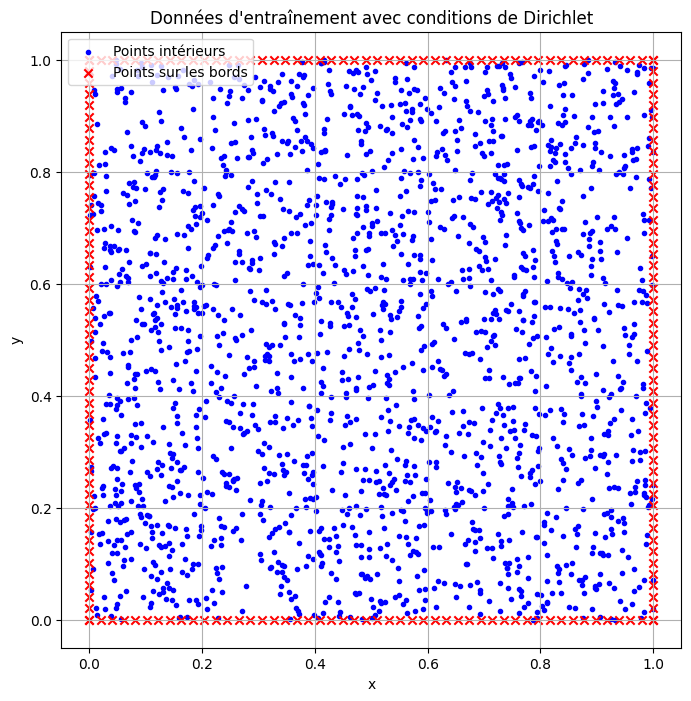

In [9]:
# Définition des données d'entraînement
n_interior = 2000  # Nombre de points à l'intérieur du domaine
n_boundary = 50  # Nombre de points sur les bords

# Points à l'intérieur du domaine
x_interior = np.random.uniform(low=0, high=1, size=(n_interior, 2))

# Points sur les bords
x_boundary = np.vstack([
    np.linspace(0, 1, n_boundary),  # Bord inférieur (y=0)
    np.zeros(n_boundary),
]).T
x_boundary = np.vstack([x_boundary, np.vstack([
    np.linspace(0, 1, n_boundary),  # Bord supérieur (y=1)
    np.ones(n_boundary),
]).T])
x_boundary = np.vstack([x_boundary, np.vstack([
    np.zeros(n_boundary),  # Bord gauche (x=0)
    np.linspace(0, 1, n_boundary),
]).T])
x_boundary = np.vstack([x_boundary, np.vstack([
    np.ones(n_boundary),  # Bord droit (x=1)
    np.linspace(0, 1, n_boundary),
]).T])

# Valeurs de la solution sur les bords (conditions de Dirichlet)
# u_boundary = np.exp(-1j * (k_x * x_boundary[:, 0] + k_y * x_boundary[:, 1]))  # Fonction définie par la condition

u_boundary_real = np.cos(k_x * x_boundary[:, 0] + k_y * x_boundary[:, 1])
u_boundary_imag = -np.sin(k_x * x_boundary[:, 0] + k_y * x_boundary[:, 1])

u_boundary = np.stack((u_boundary_real, u_boundary_imag), axis=-1)

# Affichage des données d'entraînement
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(x_interior[:, 0], x_interior[:, 1], c='b', marker='.', label='Points intérieurs')
plt.scatter(x_boundary[:, 0], x_boundary[:, 1], c='r', marker='x', label='Points sur les bords')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Données d\'entraînement avec conditions de Dirichlet')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
def compute_derivatives(x, y, u):
    dudx, dudy = tf.gradients(u, [x, y])
    dudxx = tf.gradients(dudx, x)[0]
    dudyy = tf.gradients(dudy, y)[0]
    return dudxx, dudyy

In [1]:
def custom_loss(model, x_interior, x_boundary, u_boundary, omega):
    # x_interior_tf = tf.convert_to_tensor(x_interior, dtype=tf.float32)
    # x_boundary_tf = tf.convert_to_tensor(x_boundary, dtype=tf.float32)

    # u_pred_interior = model(x_interior_tf)
    # u_pred_boundary = model(x_boundary_tf)

    # with tf.GradientTape() as tape:
    #     tape.watch(x_interior_tf)
    #     laplacian_u_interior = tf.gradients(tf.gradients(u_pred_interior, x_interior_tf), x_interior_tf)
    #     laplacian_u_interior = laplacian_u_interior[0][:, 0] + laplacian_u_interior[0][:, 1]  # Laplacien en 2D

    # with tf.GradientTape(persistent=True) as second_order_tape:
    #     with tf.GradientTape(persistent=True) as first_order_tape:
    #         first_order_tape.watch(x_interior_tf)
    #         u_pred = model(x_interior_tf)
    #         u_pred_x, u_pred_y = u_pred[:, 0], u_pred[:, 1]

    #     grad_u_pred_x = first_order_tape.gradient(u_pred_x, x_interior_tf)
    #     grad_u_pred_y = first_order_tape.gradient(u_pred_y, x_interior_tf)

    # laplacian_u_pred_x = compute_derivatives(x_interior_tf[:,0], x_interior_tf[:,1], u_pred_interior[:,0])
    # laplacian_u_pred_y = compute_derivatives(x_interior_tf[:,0], x_interior_tf[:,1], u_pred_interior[:,1])

    # laplacian_u_pred = tf.concat([laplacian_u_pred_x[:, 0] + laplacian_u_pred_x[:, 1], laplacian_u_pred_y[:, 0] + laplacian_u_pred_y[:, 1]], axis=0)

    # residue_interior = -laplacian_u_pred - omega**2 * u_pred_interior
    # loss_interior = tf.reduce_mean(tf.norm(residue_interior))

    # loss_boundary = tf.reduce_mean(tf.norm(u_pred_boundary - u_boundary))

    # return loss_interior + loss_boundary

    x_interior_tf = tf.convert_to_tensor(x_interior, dtype=tf.float32)
    x_boundary_tf = tf.convert_to_tensor(x_boundary, dtype=tf.float32)

    u_pred_interior = model(x_interior_tf)
    u_pred_boundary = model(x_boundary_tf)

    laplacian_u_pred_x_reel, laplacian_u_pred_y_reel = compute_derivatives(x_interior_tf[:, 0], x_interior_tf[:, 1], u_pred_interior[:, 0])
    laplacian_u_pred_x_im, laplacian_u_pred_y_im = compute_derivatives(x_interior_tf[:, 0], x_interior_tf[:, 1], u_pred_interior[:, 1])

    laplacian_u_pred_reel = laplacian_u_pred_x_reel + laplacian_u_pred_y_reel
    laplacian_u_pred_im = laplacian_u_pred_x_im + laplacian_u_pred_y_im

    residue_interior = (laplacian_u_pred_reel + omega**2 * u_pred_interior[:,0])**2 + (laplacian_u_pred_im + omega**2 * u_pred_interior[:, 1])**2
    loss_interior = tf.reduce_mean(residue_interior)

    # loss_boundary = tf.reduce_mean(tf.norm(u_pred_boundary - u_boundary, axis=1))

    return loss_interior #+ loss_boundary

In [5]:
# Définition du modèle PINN
model = tf.keras.Sequential([
    layers.Dense(50, activation='tanh', input_shape=(2,)),
    layers.Dense(50, activation='tanh'),
    layers.Dense(2, activation='linear')
])

In [6]:
model.compile(optimizer='adam', loss=lambda y_true, y_pred: custom_loss(model, x_interior, x_boundary, u_boundary, omega))

In [10]:
history = model.fit(
    np.vstack([x_interior, x_boundary]),
    # np.vstack([np.zeros((n_interior, 1)), u_boundary[:, None]]),
    np.vstack([np.zeros((n_interior, 2)), u_boundary]),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100


AttributeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "<ipython-input-6-cc83a4c38288>", line 1, in None  *
        lambda y_true, y_pred: custom_loss(model, x_interior, x_boundary, u_boundary, omega)
    File "<ipython-input-1-b8816426deee>", line 40, in custom_loss  *
        laplacian_u_pred_x_reel, laplacian_u_pred_y_reel = compute_derivatives(x_interior_tf[:, 0], x_interior_tf[:, 1], u_pred_interior[:, 0])
    File "<ipython-input-4-9e68009843ed>", line 3, in compute_derivatives  *
        dudxx = tf.gradients(dudx, x)[0]

    AttributeError: 'NoneType' object has no attribute 'op'


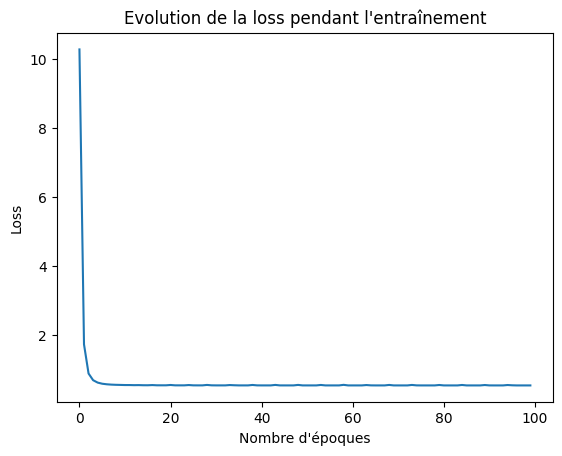

In [ ]:
# Tracer la loss en fonction du nombre d'époques
plt.plot(history.history['loss'])
plt.title('Evolution de la loss pendant l\'entraînement')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Loss')
plt.show()


313/313 [==============================] - 1s 2ms/step


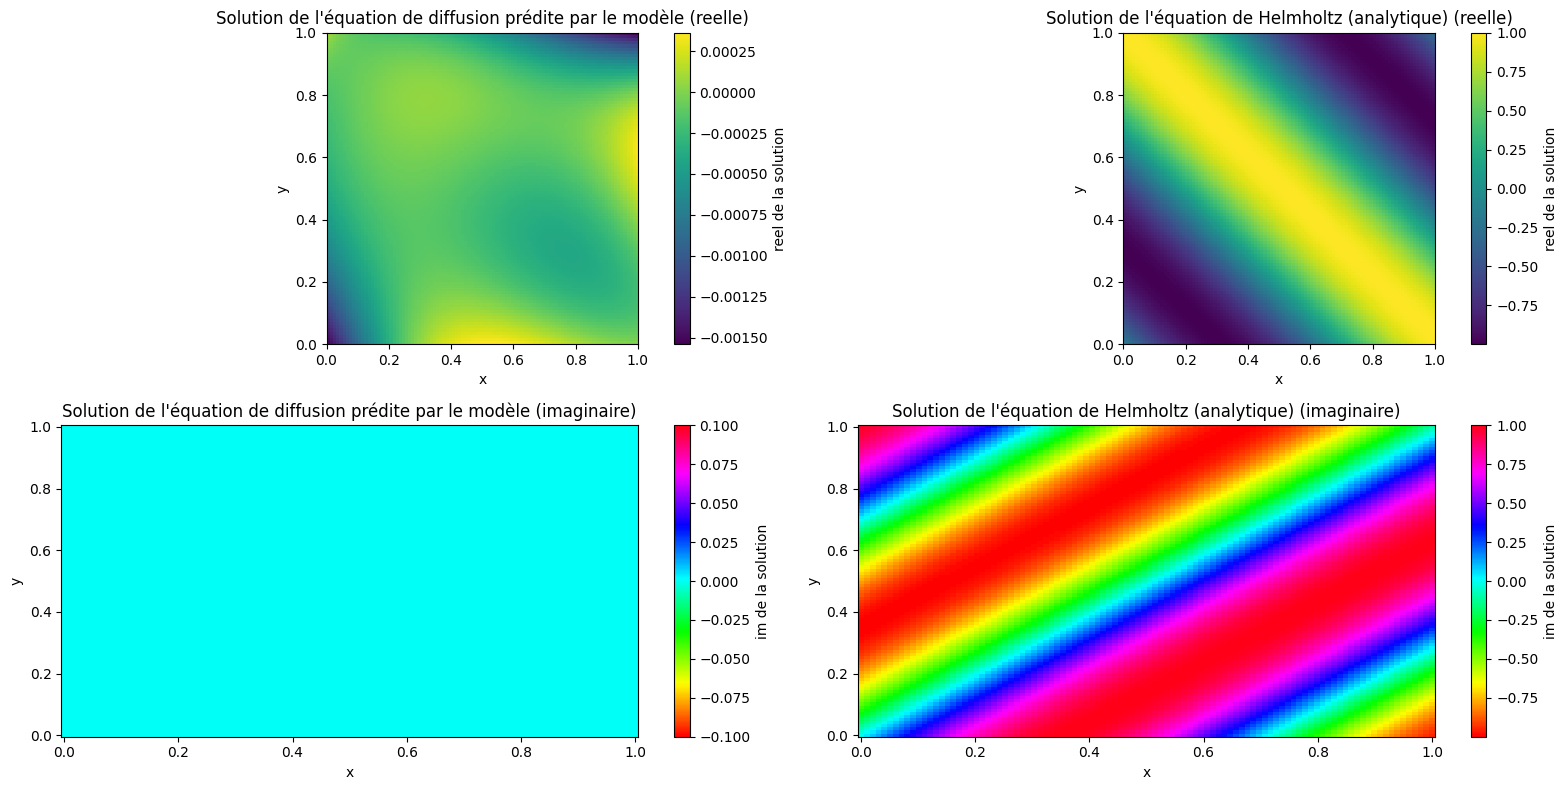

In [ ]:
# Générer une grille de points à l'intérieur du domaine
n_points = 100
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, n_points), np.linspace(0, 1, n_points))
points_grid = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

# Prédire les valeurs de la solution sur la grille
solution_predicted = model.predict(points_grid).reshape(n_points, n_points)

# Calculer les valeurs de la solution analytique sur la grille de points
analytical_solution_values = np.exp(-1j * (k_x * points_grid[:, 0] + k_y * points_grid[:, 1]))

# Tracer la solution prédite par le modèle et la solution analytique
plt.figure(figsize=(16, 8))

# Solution prédite par le modèle réelle
plt.subplot(2, 2, 1)
plt.imshow(np.real(solution_predicted), cmap='viridis', extent=[0, 1, 0, 1])
plt.colorbar(label='reel de la solution')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution de l\'équation de diffusion prédite par le modèle (reelle)')

# Solution analytique réelle
plt.subplot(2, 2, 2)
plt.imshow(np.real(analytical_solution_values).reshape(n_points, n_points), cmap='viridis', extent=[0, 1, 0, 1])
plt.colorbar(label='reel de la solution')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution de l\'équation de Helmholtz (analytique) (reelle)')

# Solution prédite par le modèle imaginaire
plt.subplot(2, 2, 3)
plt.pcolormesh(x_grid, y_grid, np.imag(solution_predicted), cmap='hsv', shading='auto')
plt.colorbar(label='im de la solution')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution de l\'équation de diffusion prédite par le modèle (imaginaire)')

# Solution analytique imaginaire
plt.subplot(2, 2, 4)
plt.pcolormesh(x_grid, y_grid, np.imag(analytical_solution_values).reshape(n_points, n_points), cmap='hsv', shading='auto')
plt.colorbar(label='im de la solution')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution de l\'équation de Helmholtz (analytique) (imaginaire)')

plt.tight_layout()
plt.show()
